In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
from src.utils import construct_sparse_adj_mat, load_json
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
from Bio import Align

In [24]:
filepaths = OmegaConf.load('../configs/filepaths/base.yaml')
aligner = Align.PairwiseAligner(
            mode="global",
            scoring="blastp"
        )
rules = pd.read_csv(
            filepath_or_buffer=Path(filepaths.artifacts) / 'minimal1224_all_uniprot.tsv',
            sep='\t'
        )
rules.set_index('Name', inplace=True)

In [31]:
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'
strategy = 'random'
metric = 'rcmcs'


reactions = load_json(Path(filepaths.data) / dataset / (toc + ".json"))
adj, idx_sample, idx_feature = construct_sparse_adj_mat(
        Path(filepaths.data) / 'sprhea' / (toc + ".csv")
    )

reactions = {k: v for k, v in reactions.items() if k in idx_feature.values()}

split_dir = Path(filepaths.scratch) / f"{dataset}_{toc}/{strategy}/3fold"

train_val = []
for i in range(3):
    train_val.append(
        pd.read_parquet(split_dir / f"train_val_{i}.parquet")
    )
test = pd.read_parquet(split_dir / 'test.parquet')

Constructing v3_folded_pt_ns sparse adjacency matrix


In [32]:
S = np.load(
    Path(filepaths.results) / 'similarity_matrices' / f"{dataset}_{toc}_{metric}.npy"
)

S = S.astype(np.float16)

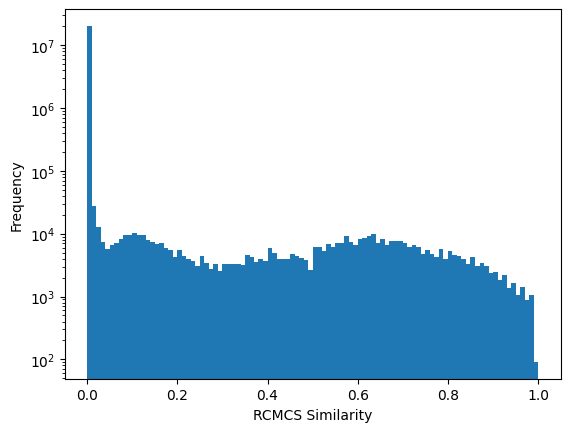

In [33]:
sims = S[np.triu_indices_from(S, k=1)]
plt.hist(sims, bins=100)
plt.yscale('log')
plt.ylabel('Frequency')
plt.xlabel(f"{metric.upper()} Similarity")
plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_split_{metric}_similarity_hist.svg", format='svg')
plt.show()

In [34]:
train_val[0].head()

,protein_idx,reaction_idx,pid,rid,protein_embedding,smarts,reaction_center,y
0,1051,341,Q91604,210,"[-0.05141502, 0.3165556, -0.034035612, 0.00583...",Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [8, 9]], [[8], [22, 23]]]",1
1,1484,341,Q63470,210,"[-0.014317952, 0.21676895, 0.12925544, 0.15106...",Nc1ncnc2c1ncn2C1OC(COP(=O)(O)OP(=O)(O)O)C(O)C1...,"[[[21], [8, 9]], [[8], [22, 23]]]",1
2,14140,2032,P52175,262,"[-0.0355334, 0.17828417, -0.00689575, -0.07090...",*C1CC(O)C(COP(=O)(O)OP(=O)(O)O)O1.Nc1ncnc2c1nc...,"[[[14], [22, 23]], [[21], [15, 16]]]",1
3,22078,6193,Q13011,8419,"[0.039852533, 0.058879, 0.047917522, 0.0027697...",CCC=CC=CCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(...,"[[[2, 3, 4, 5, 6]], [[6, 5, 4, 3, 2]]]",1
4,4290,651,O46559,3129,"[-0.019227779, 0.316851, 0.045360632, 0.119379...",CCCCCCCCC=CCCCCCCCC(=O)O.CCCCCCCCC=CCCCCCCCC(=...,"[[[17, 19], [23]], [[17, 19], [0]]]",1


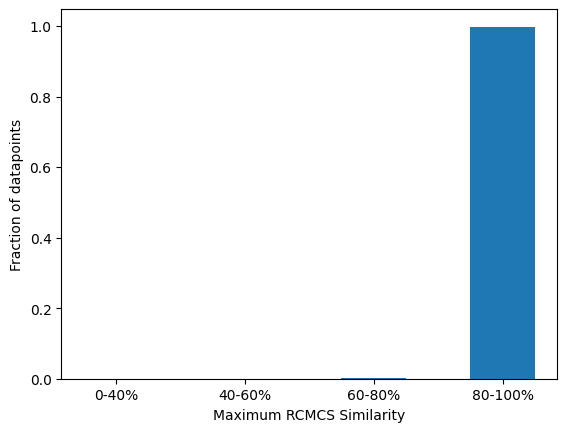

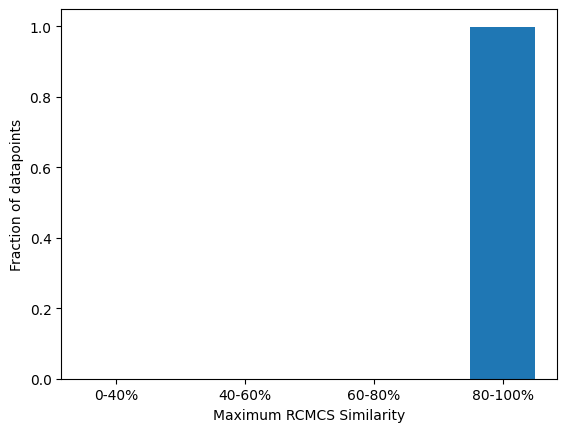

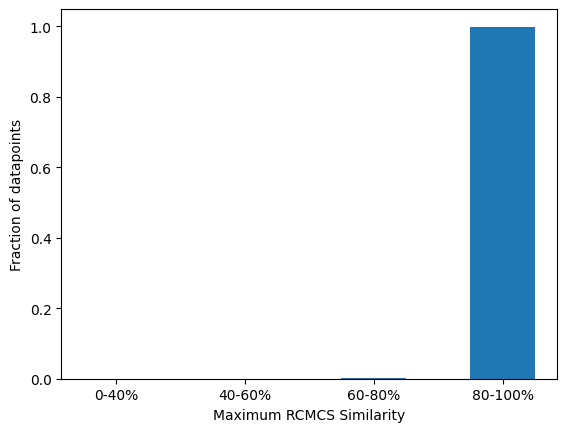

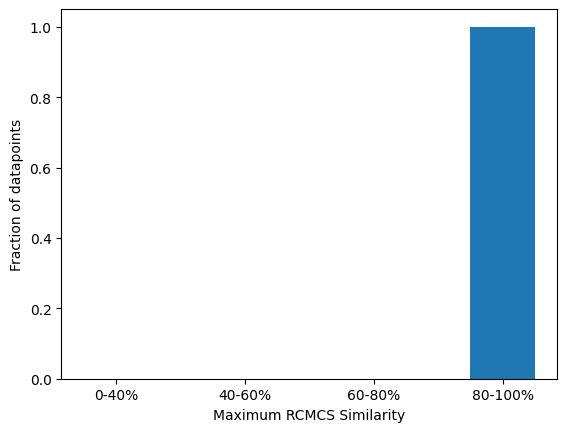

In [35]:
if strategy == 'rcmcs':
    key = 'reaction_idx'
elif strategy == 'homology':
    key = 'protein_idx'

thresholds = [1.0, 0.8, 0.6, 0.4]
thresholds = sorted(thresholds)
xticklabels = [f"0-{thresholds[0]*100:.0f}%"] + [f"{thresholds[j]*100:.0f}-{thresholds[j+1]*100:.0f}%" for j in range(len(thresholds) - 1)]

for i, val in enumerate(train_val):
    val_idx = list(set(val[key]))
    train = pd.concat([train_val[j] for j in range(3) if j != i])
    train_idx = list(set(train[key]))
    max_sims = S[:, val_idx][train_idx].max(axis=0)
    cdf = []
    for j, th in enumerate(thresholds):
        if j == 0:
            in_range = len(np.argwhere(max_sims <= th))
        else:
            less_than_th = len(np.argwhere(max_sims <= th))
            less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
            in_range = less_than_th - less_than_prev
        
        cdf.append(in_range / len(max_sims))

    plt.bar(thresholds, cdf, width=0.1)
    plt.xticks(thresholds, xticklabels)
    plt.ylabel('Fraction of datapoints')
    plt.xlabel(f"Maximum {metric.upper()} Similarity")
    plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_split_{metric}_train_val_{i}_similarity_bar_chart.svg", format='svg')
    plt.show()

val_idx = list(set(test[key]))
train = pd.concat(train_val)
train_idx = list(set(train[key]))
max_sims = S[:, val_idx][train_idx].max(axis=0)
cdf = []
for j, th in enumerate(thresholds):
    if j == 0:
        in_range = len(np.argwhere(max_sims <= th))
    else:
        less_than_th = len(np.argwhere(max_sims <= th))
        less_than_prev = len(np.argwhere(max_sims <= thresholds[j - 1]))
        in_range = less_than_th - less_than_prev
    
    cdf.append(in_range / len(max_sims))

plt.bar(thresholds, cdf, width=0.1)
plt.xticks(thresholds, xticklabels)
plt.xlabel(f"Maximum {metric.upper()} Similarity")
plt.ylabel('Fraction of datapoints')
plt.savefig(Path(filepaths.artifacts) / 'figures' / 'methods' / f"{dataset}_{toc}_{strategy}_split_{metric}_test_similarity_bar_chart.svg", format='svg')
plt.show()

In [36]:
for i, elt in enumerate(train_val):
    print(f"Fold {i}")
    print("+", len(elt[elt['y'] == 1]) / len(elt))
    print("-", len(elt[elt['y'] == 0]) / len(elt))

print(f"Test")
print("+", len(test[test['y'] == 1]) / len(test))
print("-", len(test[test['y'] == 0]) / len(test))

Fold 0
+ 0.0997212224134174
- 0.9002787775865826
Fold 1
+ 0.1000421375215476
- 0.8999578624784524
Fold 2
+ 0.10015970620230995
- 0.89984029379769
Test
+ 0.49722349584798003
- 0.50277650415202
